# Proctoring System: Cheating-Behavior Detection System
This project is created to build a simple model that can predict and classify the cheating behavior of an exam-taking student.

This project will be mainly consists of several parts:
- Installing & importing required packages
- Feature extraction using the VGG16 model
- Label encoding from the ground truth file
- Temporal features extraction using a fixed-size sliding window
- Behavior classification using the Temporal Convolutional Network (TCN) model
- (Extra) Hyperparameter tuning process using Bayesian Optimization
- Model evaluation using two evaluation methods: K-Fold and Subject-Based Evaluation.

The project will focus on **one thing** to analyze: a complex model aimed to classify whether or not a subject is cheating, as well as the cheating behavior type.

## 1. Installing Packages
We will install several packages that is needed for the project. Some packages also need to be upgraded/downgraded.

In [ ]:
## Installing the skopt library
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.0 MB/s eta 0:00:00


In [ ]:
!pip install numpy==1.19.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 28.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for numpy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for numpy
Failed to build numpy
ERROR: Could not build wheels for numpy, which is required to install pyproject.toml-based projects


In [ ]:
!pip install -U tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [ ]:
!pip install keras-tcn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.5 MB/s eta 0:00:00


## 2. Importing Packages

In [ ]:
""" Used to find all the pathnames in the selected directory for easier looping functions """
import glob
import os

""" Basic data science packages """
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

""" OpenCV library """
import cv2

""" Tensorflow packages """
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Conv2D, MaxPooling2D, TimeDistributed, Activation, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras import backend as K, Input

""" Pre-trained VGG16 model for convolutional feature extraction """
from tensorflow.keras.applications.vgg16 import VGG16

""" Scikit-learn packages """
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score, roc_curve

import pickle
import itertools
from time import time
import pprint

""" Importing TCN from keras-tcn module """
from tcn import TCN, tcn_full_summary

""" Importing XGBClassifier """
from xgboost import XGBClassifier, plot_importance, plot_tree

""" Importing Skopt functions for Hyperparameter Optimization Process """
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

## 3. Feature Extraction using the VGG16 Model

VGG16 is a pre-trained model that is a popular architecture used for object detection, as well as for transfer learning.

The default input shape of VGG16 is 224x224. The dataset we're dealing with is 480x640. To prevent any memory overload, we will reshape it first.

In [ ]:
""" Importing the VGG16 model """
VGG_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (240, 320, 3)) ## Reshaping into (240, 320)
for layer in VGG_model.layers:
    layer.trainable = False

VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 160, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 160, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 80, 128)       0     

In [ ]:
""" Function to read the ground truth file, from .txt to a dataframe column (numpy array)
This function is designed specifically for the 5 FPS extracted array """

def generate_gt(path):
  ground_truth = pd.read_csv(path, sep="\t", header=None, names=['start_time', 'end_time', 'label'])

  ground_truth['start_time'] = pd.to_datetime(ground_truth['start_time'].astype(str).str.zfill(4), format='%M%S')
  ground_truth['end_time'] = pd.to_datetime(ground_truth['end_time'].astype(str).str.zfill(4), format='%M%S')

  ground_truth['start_time'] = ground_truth['start_time'].dt.strftime('%M:%S')
  ground_truth['end_time'] = ground_truth['end_time'].dt.strftime('%M:%S')

  ground_truth['start_seconds'] = (ground_truth['start_time'].apply(lambda x: int(x.split(":")[0]) * 60 + int(x.split(":")[1])) // 2 * 10).astype(int)
  ground_truth['end_seconds'] = (ground_truth['end_time'].apply(lambda x: int(x.split(":")[0]) * 60 + int(x.split(":")[1])) // 2 * 10).astype(int)

  return ground_truth

""" Function to extract the frame. The code below will extract one frame every 5 frames (5 FPS) """
def capture_frames(video_path):

    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    i = 0

    while(i < total_frames):
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        frame = cv2.resize(frame, (240, 320))
        if ret == False:
            break
        if i == 0 or i % 5 == 0: # Capture one every 5 frames
            frames.append(frame)
        i += 1

    cap.release()
    cv2.destroyAllWindows()
    return frames

""" Function to do a batch normalization """
def batchNormalize(input, batch_size):
  num_frames = input.shape[0]

  for i in range(0, num_frames, batch_size):
    input[i:i+batch_size] = input[i:i+batch_size] / 255.0

  return input

""" Function to map the labels """
def map_label(df):
  label_map = {
      0:1, 1:2, 2:3, 3:4, 5:5, 6:6
  }
  df['label'] = df['label'].apply(lambda label: label_map[label])

  return df

The code below will run a program to:
1. Read through all the folders inside the main dataset folder for looping purposes
2. Read the selected video in each folder. We will mainly focus on the 2nd video, which is taken from the **wearcam**.
3. Each video is captured in 25 FPS. This means each second in the video will consist of 25 individual frames. Instead of extracting every single frame, we will instead extract only one every 5 frames (5 FPS). This is done so to avoid any memory overload due to the size. These extracted frames will be put into a numpy array.
4. A batch normalization process is employed. This way each values will be normalized without consuming a lot of memories.
5. The concatenated array will then be feed into the VGG16 model. The output of the model is the MaxPooling2D output, which are the features extracted from both the convolutional and pooling layers.
6. Principal Component Analysis (PCA) is used to reduce the number of features on the dataset. The threshold is 90%, meaning if the selected features are already describing 90% of the dataset complexity, the remaining will be discarded since they won't add much.
7. The ground truth file is a .txt file. We will use this to label each frame with technique as follows:
  - All the frames that are in the range of a timestamp in the ground truth file will be labelled the same. For example: "0135 0140 1" means every frames that are inside the timestamp range between 01:35 to 01:40 will be marked as 1.
  - This will be done to every single timestamp. All the timestamps that are not labelled as any of the ground truth labels will be labelled as 0, indicating a non-cheating behavior.
  - To avoid any misunderstanding, we will remap the labels. This is done since based on our observation, the label 4 is absent on the dataset. This means instead of having [0, 1, 2, 3, 5, 6] as the labels, we will instead have [1, 2, 3, 4, 5, 6], where 1 is now the non-cheating behavior.
8. The processed dataset will be exported into a csv file, for future uses.
  

In [ ]:
counter = 0
pca = PCA(n_components = 100)

for directory_path in glob.glob('/content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/*'):
    counter = counter + 1
    folderName = directory_path.split('\\')[-1]
    print("Working with file in Folder: " + folderName)
    for img_path in glob.glob(os.path.join(directory_path, "*2.avi")):
        frames = capture_frames(img_path)
        frames_array = np.array(frames)
        frames_array = frames_array.astype(np.float)

        print("Input Shape: " + str(frames_array.shape))

        batch_size = 100  # Adjust this value based on your available memory
        frames_array = batchNormalize(frames_array, batch_size = 100)
        frames_array = frames_array.reshape((-1, 240, 320, 3))

        feature_extractor = VGG_model.predict(frames_array)
        features = feature_extractor.reshape(feature_extractor.shape[0], -1)
        df = pd.DataFrame(features)

        df_pca = pca.fit_transform(df)
        df_transformed = pd.DataFrame(df_pca)

        gt_path = folderName + '/gt.txt'

        ground_truth = generate_gt(gt_path)

        df_transformed['label'] = 0
        for index, row in ground_truth.iterrows():
          df_transformed.loc[row['start_seconds']:row['end_seconds'], 'label'] = row['label']

        df_transformed = map_label(df_transformed)
        df_transformed.to_csv(folderName + '/' + 'subject' + str(counter) + '_preprocessed2' + '.csv')

Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject10


<ipython-input-4-fbca2484fb25>:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  frames_array = frames_array.astype(np.float)


Input Shape: (7688, 320, 240, 3)
241/241 [==============================] - 59s 206ms/step


## 4. Exploratory Data Analysis

In this part, we will look into the extracted features, as well as the label distributions.

Since the dataset consists of individual videos taken from different subjects, we will first combine all of them into a single Pandas DataFrame.

In [ ]:
df_full = pd.DataFrame()
for directory_path in glob.glob('/content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/*'):
    folderName = directory_path.split('\\')[-1]
    print("Working with file in Folder: " + folderName)
    for file_path in glob.glob(os.path.join(directory_path, "*_preprocessed2.csv")):
      df = pd.read_csv(file_path, index_col = 0)
      df_full = df_full.append(df)

Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject1


<ipython-input-6-293950f76283>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = df_full.append(df)


Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject2


<ipython-input-6-293950f76283>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = df_full.append(df)


Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject3


<ipython-input-6-293950f76283>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = df_full.append(df)


Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject4


<ipython-input-6-293950f76283>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = df_full.append(df)


Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject5


<ipython-input-6-293950f76283>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = df_full.append(df)


Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject6


<ipython-input-6-293950f76283>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = df_full.append(df)


Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject7


<ipython-input-6-293950f76283>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = df_full.append(df)


Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject8


<ipython-input-6-293950f76283>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = df_full.append(df)


Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject9


<ipython-input-6-293950f76283>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = df_full.append(df)


Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject10
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject_all_preprocessed.h5
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/Training


<ipython-input-6-293950f76283>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = df_full.append(df)


In [ ]:
df_full

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,-2.008385,11.641023,-0.123253,-2.346067,2.726149,0.236202,0.126863,-2.907123,-0.896129,-3.133649,...,1.437048,-0.537427,0.266311,0.138212,1.476840,0.031930,0.330587,0.665122,-0.478120,1
1,-2.756563,11.368041,-0.526131,-2.309363,2.323543,0.527396,0.049078,-3.365620,-1.552127,-2.941445,...,1.392165,-0.587018,-0.072247,0.274483,1.421823,0.063359,0.224559,0.596049,-0.347141,1
2,-2.919900,11.156833,-1.490655,-2.212414,2.534146,1.122435,-0.040006,-3.459456,-1.304269,-3.133263,...,1.359447,-0.630618,0.227116,0.213347,1.445056,0.111586,0.316371,0.570965,-0.380819,1
3,-2.242123,10.351804,-1.685520,-2.872498,2.492085,0.995163,-0.197528,-3.463079,-1.417928,-3.234936,...,1.341408,-0.822710,0.208127,0.170503,1.482699,-0.093624,-0.149271,0.592460,-0.656326,1
4,-2.400982,10.040668,-2.118994,-2.663022,2.295844,1.118941,-0.118533,-3.458589,-1.473292,-3.015138,...,1.346861,-0.756953,0.153718,0.180115,1.551023,-0.189443,0.111103,0.641271,-0.837342,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7683,-9.847402,-1.830313,-3.445506,6.479584,1.552819,-4.293254,3.902317,1.745238,1.925829,0.742652,...,-0.054792,0.274369,-0.334365,-0.591041,0.949822,0.016631,0.399544,0.489928,-0.527155,1
7684,-9.946204,-2.978902,-3.209443,7.056261,1.560582,-4.365214,3.699889,2.401286,1.715507,0.342679,...,0.332521,0.400917,-0.337334,-0.960960,0.505218,0.119298,-0.074620,0.845462,-0.747534,1
7685,-9.589018,-3.147592,-2.670407,7.542990,1.281223,-3.875958,4.042407,2.006762,1.827259,-0.137245,...,0.242068,0.720882,-0.381940,-0.754650,0.565433,0.095356,0.081634,0.805304,-0.665739,1
7686,-9.087818,-3.929554,-1.619829,8.057692,1.107806,-3.752260,3.194540,2.063162,2.017336,-0.236557,...,0.757288,0.650057,-0.545395,-1.003067,0.284711,0.029985,-0.133987,1.048331,-0.773662,1


As we can see, we have 51178 rows with 101 columns, 100 of them are feature columns, and a label column.

**Checking the label distributions**

We want to check the label distributions. Keep in mind that label 1 indicates a non-cheating behavior, while the rest of the labels indicate a cheating behavior with different types.

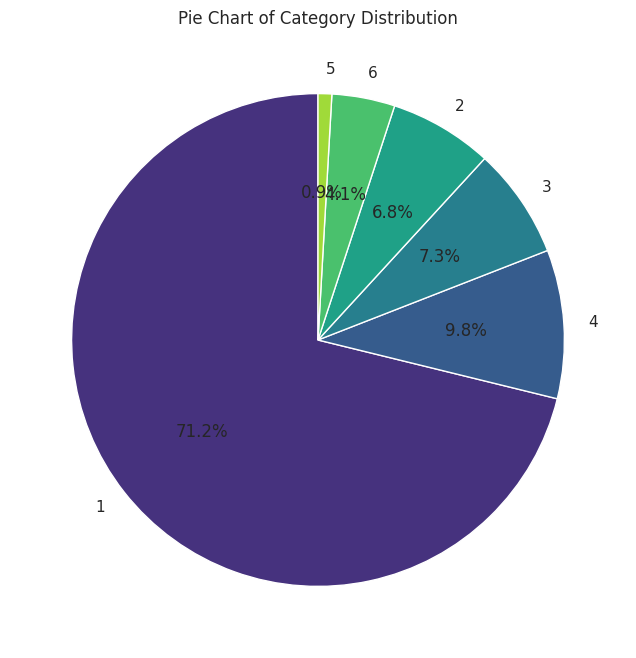

In [ ]:
value_counts = df_full['label'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels = value_counts.index, autopct = '%1.1f%%', startangle = 90, colors = sns.color_palette('viridis'))
plt.title('Pie Chart of Category Distribution')
plt.show()

We can see that around 70% of the activities are labelled as non-cheating.

In [ ]:
df_full['label'].value_counts()

1    36421
4     4992
3     3714
2     3475
6     2116
5      460
Name: label, dtype: int64

In [ ]:
df_full.describe()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
count,5.117800e+04,5.117800e+04,5.117800e+04,5.117800e+04,5.117800e+04,5.117800e+04,5.117800e+04,5.117800e+04,5.117800e+04,5.117800e+04,...,5.117800e+04,5.117800e+04,5.117800e+04,5.117800e+04,5.117800e+04,5.117800e+04,5.117800e+04,5.117800e+04,5.117800e+04,51178.000000
mean,1.642698e-07,-4.875460e-08,-2.527984e-07,-2.421823e-07,-2.071407e-07,2.789526e-07,-1.180589e-07,2.753084e-07,-2.108415e-07,4.716696e-07,...,-6.947871e-08,-2.164551e-08,-1.966882e-08,1.427342e-07,9.540279e-08,9.228372e-08,-4.083496e-09,3.109815e-07,-1.976717e-09,1.748349
std,8.373221e+00,6.638098e+00,4.848872e+00,4.048009e+00,3.595222e+00,3.242473e+00,2.950966e+00,2.718034e+00,2.550194e+00,2.366907e+00,...,4.921179e-01,4.886630e-01,4.846374e-01,4.811909e-01,4.775185e-01,4.748606e-01,4.695445e-01,4.650199e-01,4.619101e-01,1.361443
min,-1.313255e+01,-1.608538e+01,-1.375059e+01,-1.198978e+01,-1.395492e+01,-1.016752e+01,-1.054869e+01,-1.074404e+01,-1.216635e+01,-8.908802e+00,...,-2.876568e+00,-2.504057e+00,-2.646440e+00,-2.467735e+00,-2.764793e+00,-2.766183e+00,-2.750161e+00,-2.704704e+00,-2.619611e+00,1.000000
25%,-6.231587e+00,-5.213461e+00,-3.388383e+00,-2.914222e+00,-2.466644e+00,-2.228251e+00,-1.883173e+00,-1.733384e+00,-1.715889e+00,-1.478256e+00,...,-2.761898e-01,-2.825191e-01,-2.754297e-01,-2.771290e-01,-2.710539e-01,-2.741138e-01,-2.677054e-01,-2.657062e-01,-2.652333e-01,1.000000
50%,-2.638513e+00,-5.217705e-02,-3.703960e-01,-4.059525e-01,-1.380716e-01,-4.783204e-03,-3.134482e-02,-2.425141e-02,-2.578044e-02,-3.871045e-02,...,1.726298e-03,-5.268350e-03,-5.038056e-03,2.171220e-03,-3.518194e-03,-3.163786e-03,-1.645646e-03,5.383153e-04,2.877004e-04,1.000000
75%,4.400983e+00,5.005561e+00,3.144019e+00,2.565021e+00,2.218799e+00,2.107508e+00,1.793100e+00,1.548921e+00,1.636330e+00,1.391468e+00,...,2.833603e-01,2.794868e-01,2.693025e-01,2.758246e-01,2.725382e-01,2.738575e-01,2.693149e-01,2.641788e-01,2.632199e-01,2.000000
max,2.713036e+01,1.831921e+01,1.751471e+01,1.468731e+01,2.044761e+01,1.335961e+01,1.224738e+01,1.207142e+01,1.299840e+01,1.207197e+01,...,4.239640e+00,3.566776e+00,2.911677e+00,3.979574e+00,3.499123e+00,3.744512e+00,4.049323e+00,3.418414e+00,3.611552e+00,6.000000


We will also focus on two approaches,
1. Building a simple classifier using traditional ML model (XGBoost)
2. Building an advanced deep learning model using temporal features from the dataset (TCN)

Since the problem we are dealing with is related to human activity recognition, we might want to see whether or not a temporal feature extraction will boost the performance of our classifier significantly. These features will capture temporal features since as we can see in our dataset, some activities (both cheating and non-cheating) can last for a period of time.

To determine the right size of our temporal window, we will first investigate the average duration (in frames) of our cheating activities.

In [ ]:
counter = 0
total = 0
count = 0

for directory_path in glob.glob('/content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/*'):
    counter = counter + 1
    folderName = directory_path.split('\\')[-1]
    for file_path in glob.glob(os.path.join(directory_path, "*gt.txt")):
      ground_truth = pd.read_csv(file_path, sep="\t", header=None, names=["start_time", "end_time", "label"])

      ground_truth["start_time"] = pd.to_datetime(ground_truth["start_time"].astype(str).str.zfill(4), format="%M%S")
      ground_truth["end_time"] = pd.to_datetime(ground_truth["end_time"].astype(str).str.zfill(4), format="%M%S")

      ground_truth["start_time"] = ground_truth["start_time"].dt.strftime("%M:%S")
      ground_truth["end_time"] = ground_truth["end_time"].dt.strftime("%M:%S")

      ground_truth["start_seconds"] = (ground_truth["start_time"].apply(lambda x: int(x.split(":")[0]) * 60 + int(x.split(":")[1])) // 2 * 10).astype(int)
      ground_truth["end_seconds"] = (ground_truth["end_time"].apply(lambda x: int(x.split(":")[0]) * 60 + int(x.split(":")[1])) // 2 * 10).astype(int)

      ## Capturing the duration of behavior, subtracting the end time and starting time
      ground_truth['duration'] = ground_truth['end_seconds'] - ground_truth['start_seconds']
      total = total + ground_truth['duration'].sum()
      count = count + ground_truth['duration'].count()
      print(f"Subject %s average cheating duration: %s frames" %(counter, ground_truth['duration'].mean()))

print()
print(f"Total average cheating duration: %s frames" % str(total / count))

Subject 1 average cheating duration: 75.9090909090909 frames
Subject 2 average cheating duration: 181.42857142857142 frames
Subject 3 average cheating duration: 86.84210526315789 frames
Subject 4 average cheating duration: 152.0 frames
Subject 5 average cheating duration: 59.583333333333336 frames
Subject 6 average cheating duration: 48.57142857142857 frames
Subject 7 average cheating duration: 69.2 frames
Subject 8 average cheating duration: 45.55555555555556 frames
Subject 9 average cheating duration: 130.0 frames
Subject 10 average cheating duration: 88.70967741935483 frames

Total average cheating duration: 75.55555555555556 frames


We can see that in average, some cheating behaviors might take around 50-75 frames (around 10-15 seconds, since we're capturing the image in 5 FPS). We will use 50 frames as the bare minimum of our temporal window size.

## 5. K-Fold Based Model

Our first evaluation method is K-Fold Cross Validation, a simple evaluation method for our model development. We will use k = 5 for this project. We will also train two classifier, the first one using XGBClassifier, and the second one using Temporal Convolutional Network (TCN).

### Using XGBClassifier (no temporal features)

We will be using the simple tabular data for this model. The dataset will be split into training and testing dataset, with proportion of 80:20.

In [ ]:
df_full

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,-2.008385,11.641023,-0.123253,-2.346067,2.726149,0.236202,0.126863,-2.907123,-0.896129,-3.133649,...,1.437048,-0.537427,0.266311,0.138212,1.476840,0.031930,0.330587,0.665122,-0.478120,1
1,-2.756563,11.368041,-0.526131,-2.309363,2.323543,0.527396,0.049078,-3.365620,-1.552127,-2.941445,...,1.392165,-0.587018,-0.072247,0.274483,1.421823,0.063359,0.224559,0.596049,-0.347141,1
2,-2.919900,11.156833,-1.490655,-2.212414,2.534146,1.122435,-0.040006,-3.459456,-1.304269,-3.133263,...,1.359447,-0.630618,0.227116,0.213347,1.445056,0.111586,0.316371,0.570965,-0.380819,1
3,-2.242123,10.351804,-1.685520,-2.872498,2.492085,0.995163,-0.197528,-3.463079,-1.417928,-3.234936,...,1.341408,-0.822710,0.208127,0.170503,1.482699,-0.093624,-0.149271,0.592460,-0.656326,1
4,-2.400982,10.040668,-2.118994,-2.663022,2.295844,1.118941,-0.118533,-3.458589,-1.473292,-3.015138,...,1.346861,-0.756953,0.153718,0.180115,1.551023,-0.189443,0.111103,0.641271,-0.837342,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7683,-9.847402,-1.830313,-3.445506,6.479584,1.552819,-4.293254,3.902317,1.745238,1.925829,0.742652,...,-0.054792,0.274369,-0.334365,-0.591041,0.949822,0.016631,0.399544,0.489928,-0.527155,1
7684,-9.946204,-2.978902,-3.209443,7.056261,1.560582,-4.365214,3.699889,2.401286,1.715507,0.342679,...,0.332521,0.400917,-0.337334,-0.960960,0.505218,0.119298,-0.074620,0.845462,-0.747534,1
7685,-9.589018,-3.147592,-2.670407,7.542990,1.281223,-3.875958,4.042407,2.006762,1.827259,-0.137245,...,0.242068,0.720882,-0.381940,-0.754650,0.565433,0.095356,0.081634,0.805304,-0.665739,1
7686,-9.087818,-3.929554,-1.619829,8.057692,1.107806,-3.752260,3.194540,2.063162,2.017336,-0.236557,...,0.757288,0.650057,-0.545395,-1.003067,0.284711,0.029985,-0.133987,1.048331,-0.773662,1


To make things easier, for XGBClassifier we will remap back the labels to its original number.

In [ ]:
def map_label(df):
  label_map = {
      1:0, 2:1, 3:2, 4:3, 5:4, 6:5
  }
  df['label'] = df['label'].apply(lambda label: label_map[label])

  return df

df_full = map_label(df_full)

We will also perform a hyperparameter optimization, using Bayesian Optimization.

In [ ]:
""" Defining a function to report the performance of each iterations and returning the best parameter configuration """
def report_perf(optimizer, X, y, title, callbacks = None):
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback = callbacks)
    else:
        optimizer.fit(X, y)
    best_score = optimizer.best_score_
    best_score_std = optimizer.cv_results_['std_test_score'][optimizer.best_index_]
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start,
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [ ]:
labels = ['label']
features = df_full.drop(columns = ['label']).columns

""" Train test split, with 80:20 proportion """
train_df, test_df = train_test_split(df_full, test_size = 0.2, random_state = 42, shuffle = True)

x_train, y_train = train_df[features], train_df[labels]
x_val, y_val = test_df[features], test_df[labels]

In [ ]:
""" Defining the base model """
xgb_untuned = XGBClassifier(device = "cuda")

In [ ]:
""" Defining the search space of our HPO """
search_spaces = {
    'learning_rate': Real(0.01, 1.0, 'uniform'),
    'max_depth': Integer(2, 12),
    'subsample': Real(0.1, 1.0, 'uniform'),
    'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
    'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
    'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
    'n_estimators': Integer(50, 5000)
}

In [ ]:
""" Instantiating our Bayesian Optimization object """
opt = BayesSearchCV(
    estimator = xgb_untuned,
    search_spaces = search_spaces,
    cv = 5,
    n_jobs = 1,
    n_iter = 10,
    return_train_score = False,
    refit = True,
    iid = False,
    optimizer_kwargs = {'base_estimator': 'GP'},        # optimizer parameters: we will use Gaussian Process (GP)
    random_state = 0,
    verbose = 100
)

/usr/local/lib/python3.10/dist-packages/skopt/searchcv.py:300: UserWarning: The `iid` parameter has been deprecated and will be ignored.
  warnings.warn("The `iid` parameter has been deprecated "


In [ ]:
best_params_xgb = report_perf(
    opt, x_train, y_train, 'XGBoost',
    callbacks = [DeltaYStopper(0.0001)]
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START colsample_bytree=0.5778677484569327, learning_rate=0.6793187137881445, max_depth=8, n_estimators=3251, reg_alpha=85.87438316565517, reg_lambda=98.05562626781331, subsample=0.21526179068277768


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:02:05] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV 1/5; 1/1] END colsample_bytree=0.5778677484569327, learning_rate=0.6793187137881445, max_depth=8, n_estimators=3251, reg_alpha=85.87438316565517, reg_lambda=98.05562626781331, subsample=0.21526179068277768;, score=0.787 total time=  15.7s
[CV 2/5; 1/1] START colsample_bytree=0.5778677484569327, learning_rate=0.6793187137881445, max_depth=8, n_estimators=3251, reg_alpha=85.87438316565517, reg_lambda=98.05562626781331, subsample=0.21526179068277768
[CV 2/5; 1/1] END colsample_bytree=0.5778677484569327, learning_rate=0.6793187137881445, max_depth=8, n_estimators=3251, reg_alpha=85.87438316565517, reg_lambda=98.05562626781331, subsample=0.21526179068277768;, score=0.794 total time=  14.3s
[CV 3/5; 1/1] START colsample_bytree=0.5778677484569327, learning_rate=0.6793187137881445, max_depth=8, n_estimators=3251, reg_alpha=85.87438316565517, reg_lambda=98.05562626781331, subsample=0.21526179068277768
[CV 3/5; 1/1] END colsample_bytree=0.5778677484569327, learning_rate=0.6793187137881445, m

In [ ]:
best_params_xgb

OrderedDict([('colsample_bytree', 0.43258327966047017),
             ('learning_rate', 0.4457817974015126),
             ('max_depth', 5),
             ('n_estimators', 4001),
             ('reg_alpha', 7.012239028725165),
             ('reg_lambda', 74.30097944059798),
             ('subsample', 0.7607809984958609)])

Now that we have our best configurations, we can put the numbers into our XGBClassifier parameters.

In [ ]:
""" Setting our tuned classifier, using the numbers returned from previous optimization process """
xgb_tuned = XGBClassifier(
    device = 'cuda',
    colsample_bytree = 0.43258327966047017,
    learning_rate = 0.4457817974015126,
    max_depth = 5,
    n_estimators = 4001,
    reg_alpha = 7.012239028725165,
    reg_lambda = 74.30097944059798,
    subsample = 0.7607809984958609
)

We will perform a K-Fold CV with k = 5. A random_state is employed to make sure every run has the same sample seeds.

In [ ]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
cv_scores = cross_val_score(xgb_tuned, x_train, y_train, cv = kf, scoring = 'accuracy')

print(cv_scores)
print("Mean Score: " + str(cv_scores.mean()))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:30:38] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[0.93369154 0.92648675 0.92843185 0.93087445 0.92843185]
Mean Score: 0.9295832882684918


We can see that the average accuracy across 5 runs are 92.9%. While it is relatively good score, we found out on our EDA process before that the labels are a bit imbalanced. We will use another metric, F1 Score, to tell whether or not our model can be generalized across all the labels.

In [ ]:
xgb_tuned.fit(x_train, y_train)
probs = xgb_tuned.predict(x_val)
probs_proba = xgb_tuned.predict_proba(x_val)[:, 1]

print("Tuned XGB classifier F1 Score: " + str(f1_score(y_val, probs, average = 'macro')))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:40:35] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Tuned XGB classifier F1 Score: 0.8856699871027839


We can see that the score is 88.5. While it is a bit lower than the accuracy, the performance is still good since it does not drop significantly. A model that does not generalize well across all labels will perform much worse.

In [ ]:
## Saving our tuned model
pickle.dump(xgb_tuned, open('/content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/Training/XGBTuned.pkl', 'wb'))

In [ ]:
## Only run when you want to load the model
xgb_tuned = pickle.load(open('/content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/Training/XGBTuned.pkl', 'rb'))

We will also plot the confusion matrix to see the differences between the predicted and the true labels.

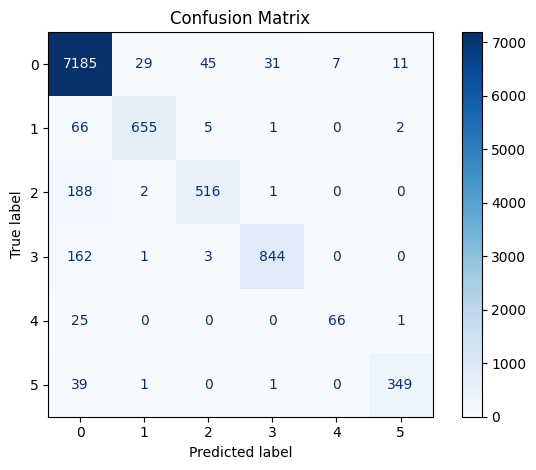

In [ ]:
## Plotting the confusion matrix
plt.style.use('default')
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_val, probs), display_labels=['0', '1', '2', '3', '4', '5'])
disp.plot(cmap = 'Blues', values_format = '')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

For better visualization, we will also plot the confusion matrix on percentages.

[Text(0.5, 1.0, 'Confusion Matrix for Tuned TCN Model')]

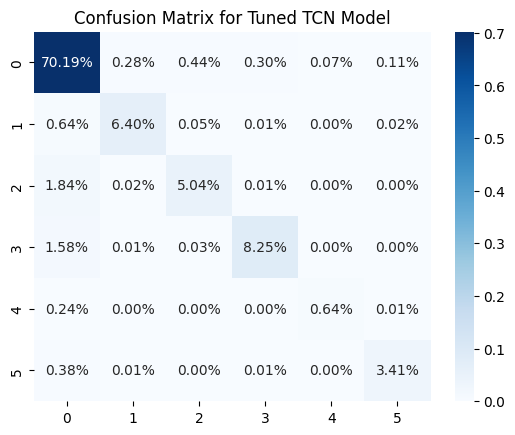

In [ ]:
import seaborn as sns
labels = ['0', '1', '2', '3', '4', '5']
conf_matrix = confusion_matrix(y_val, probs)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot = True, fmt = '.2%', cmap = 'Blues', xticklabels = labels, yticklabels = labels).set(title = 'Confusion Matrix for Tuned TCN Model')

We can see that around 70% of all the datasets are correctly classified as "non-cheating"/0.

### Using Temporal Convolutional Network (TCN)

The second model is the Temporal Convolutional Network (TCN). While TCN can be used along with generic dense layers to produce outputs from singular data, we can also use a TimeDistributed() wrapper to apply a layer to every temporal slice of an input.

We will first extract the temporal feature of our concatenated dataset.

#### 1. Concatenating All Dataset into a Single Numpy Array

In [ ]:
x = []
y = []
y_onehot = []
label_full = pd.DataFrame(columns = ['label'])
label_shape = []
counter = 0

"""Looping only through the dataset folders"""
for directory_path in glob.glob('/content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/*')[0:10]:
    counter = counter + 1
    folderName = directory_path.split('\\')[-1]
    print("Working with file in Folder: " + folderName)
    x.append([])
    y.append([])

    for csv_path in glob.glob(os.path.join(directory_path, "*preprocessed2.csv")):
      df = pd.read_csv(csv_path, index_col = 0)
      df_length = len(df)
      label_shape.append(df_length)
      label_full = pd.concat([label_full, df[['label']]])

      df_label = df['label']
      df = df.drop(columns = ['label'])

      x[-1].append(np.hstack([np.reshape(np.array(df[col]), (-1, 1)) for col in df.columns]))
      assert x[-1][-1].dtype == np.float64
      y[-1].append(df_label.astype('int64'))

label_binarizer = LabelBinarizer()
label_ohe = label_binarizer.fit_transform(label_full['label'].astype('int64'))

start = 0
y_onehot = []
for i in label_shape:
    end = i
    y_onehot.append([])
    y_onehot[-1].append(label_ohe[start:(start + end)])
    start = i

Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject1
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject2
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject3
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject4
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject5
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject6
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject7
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject8
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (Sm

In [ ]:
"""Saving the augmented data into HDF5 file"""
path_h5 = '/content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject_all_preprocessed.h5'
pickle.dump({'data_X': x, 'data_Y': y, 'data_Y_one_hot': y_onehot},
                        open(path_h5, 'wb'))

#### 2. Extracting Temporal Features

In [ ]:
"""Load the saved concatenated HDF5 file"""
path_h5 = '/content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject_all_preprocessed.h5'
loaded_data = pickle.load(open(path_h5, 'rb'))
data_X, data_Y, data_Y_one_hot = loaded_data['data_X'], loaded_data['data_Y'], loaded_data['data_Y_one_hot']

The functions below will generate temporal windows across the dataset with fixed size.

In [ ]:
def zip_equal(*args):
    fallback = object()
    for combination in itertools.zip_longest(*args, fillvalue = fallback):
        yield combination

def extract_windows(x, y, window_length, padding_features, downsample):
    res_x = []
    res_y = []

    for x_item, y_item in zip_equal(x, y):
        padding_size_x = padding_features
        padding_size_y = 0

        padded_x = np.pad(x_item, ((padding_size_x, padding_size_x), (0, 0)), 'reflect')
        padded_y = np.pad(y_item, ((padding_size_y, padding_size_y), (0, 0)), 'constant')

        window_length_x = window_length + 2 * padding_features
        res_x += [padded_x[i:i + window_length_x, :] for i in range(0, padded_x.shape[0] - window_length_x + 1, downsample)]
        res_y += [padded_y[i:i + window_length, :] for i in range(0, padded_y.shape[0] - window_length + 1, downsample)]

    return res_x, res_y

We see that in our EDA step, the average duration (in frames) of the cheating behavior is around 50-75. We have also determined to use 50 as our window_size. These will be paired with an overlap of 40.

In [ ]:
window_size = 50
overlap = 40
downsample = window_size - overlap
padding_features = 0

windows_x = []
windows_y = []

for subset_index in range(len(data_X)):
    x, y, = extract_windows(
        data_X[subset_index],
        data_Y_one_hot[subset_index],
        window_length = window_size,
        downsample = downsample,
        padding_features = padding_features
    )
    windows_x.append(np.array(x))
    windows_y.append(np.array(y))

In [ ]:
num_classes = 6

"""Get train and val set"""
train_df = np.concatenate(windows_x)
label = np.concatenate(windows_y)

print("Shape of the final array: " + str(np.array(train_df).shape))
print(f"Number of windows created: %s" % str(len(train_df)))

Shape of the final array: (5074, 50, 100)
Number of windows created: 5074


#### 3. Modelling

Now that we have our temporal features extracted, we will advance to the modelling section.

The shape of our data now is (5074, 50, 100), meaning there are 5074 windows of shape (50, 100).

Using the same configuration as our XGBClassifier model, we will do a train and test split with 80:20 proportion.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df, label, test_size=0.2, random_state = 42)

Since our data is in a 3D shape array, using the built-in tensorflow f1 score metrics is not possible. Instead, we will build our own f1 score function to calculate the F1 Score of our evaluation model.

In [ ]:
def f1_score_function(y_true, y_pred):
    num_classes = y_pred.shape[-1]
    f1_scores = []
    for class_i in range(num_classes):
        pred_labels = K.argmax(y_pred, axis=-1)
        tp = K.sum(K.cast(y_true[:, :, class_i], 'float64') * K.cast(K.equal(pred_labels, class_i), 'float64'))
        all_p_detections = K.sum(K.cast(K.equal(pred_labels, class_i), 'float64'))
        all_p_true = K.sum(y_true[:, :, class_i])

        precision = tp / (all_p_detections + K.epsilon())
        recall = tp / (tf.cast(all_p_true, tf.float64) + K.epsilon())
        f_score = 2 * precision * recall / (precision + recall + K.epsilon())

        f1_scores.append(f_score)

    overall_f1_score = K.mean(K.stack(f1_scores), axis=0)
    return overall_f1_score

We will build our model using the Keras Functional API for easier structuring. The model will accept an input of the same shape as our data, while the output is a dense layer with softmax activation function wrapped inside a time distributed layer. We will also use our defined f1 score function as one of the metrics.

In [ ]:
def create_model(num_classes, train_data_shape, dropout_rate, nb_filters, nb_stacks, kernel_size, dilation_count, padding_mode):

    in_model = Input(batch_shape = (None, train_data_shape[1], train_data_shape[2]))

    model = TCN(return_sequences = True,
                dropout_rate = dropout_rate,
                nb_filters = nb_filters,
                nb_stacks = nb_stacks,
                kernel_size = kernel_size,
                dilations = [2**i for i in range(dilation_count)],
                padding = padding_mode,
                activation = 'relu',
                kernel_initializer = 'random_uniform',
                use_batch_norm = False
                )(in_model)

    out_model = TimeDistributed(Dense(num_classes, activation = 'softmax'))(model)

    model = Model(in_model, out_model)
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy',
                        metrics = ['accuracy', f1_score_function])
    model.summary()

    return model

The function below will do the evaluation process across all the predicted labels.

In [ ]:
def evaluate_test_cv(model, X, y, batch_size):

    batch_size = batch_size
    original_len = X.shape[0]
    target_len = int(np.ceil(float(original_len) / batch_size)) * batch_size
    X = np.pad(X, pad_width = ((0, target_len - X.shape[0]), (0, 0), (0, 0)), mode = 'constant')

    # take only the needed predictions
    res_proba = model.predict(X, batch_size = batch_size)[:original_len]
    results = {}

    res = np.argmax(res_proba, axis=-1)

    raw_results = {'true': y, 'pred': res_proba}

    results['accuracy'] = (np.mean(res == np.argmax(y, axis=-1)))

    results['F1_Score'] = f1_score_function(y, res_proba)
    return raw_results, results

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 50, 100)]         0         
                                                                 
 tcn_4 (TCN)                 (None, 50, 64)            112192    
                                                                 
 time_distributed_4 (TimeDi  (None, 50, 6)             390       
 stributed)                                                      
                                                                 
Total params: 112582 (439.77 KB)
Trainable params: 112582 (439.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
115/115 [==============================] - 5s 14ms/step - loss: 0.9555 - accuracy: 0.6987 - f1_score_function: 0.1532 - val_loss: 0.8476 - val_accuracy: 0.6963 - val_f1_score_function: 0.1777
Epoch 2/50
115

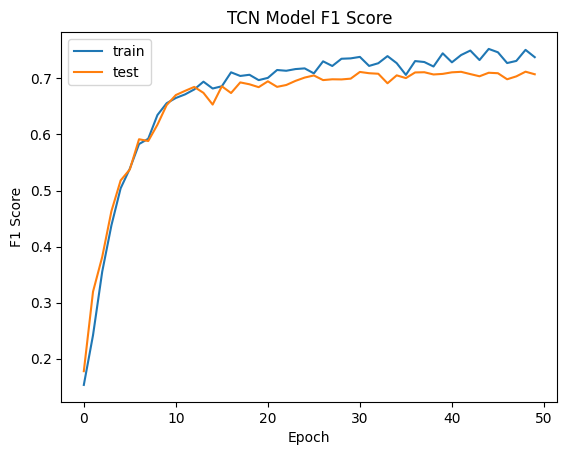

In [ ]:
model = create_model(
    num_classes = 6,
    train_data_shape = X_train.shape,
    dropout_rate = 0.2,
    nb_filters = 64,
    nb_stacks = 1,
    kernel_size = 3,
    dilation_count = 4,
    padding_mode = 'same',
)

batch_size = 32

history_tuned = model.fit(
      X_train, y_train,
      epochs = 50,
      batch_size = batch_size,
      shuffle = True,
      validation_split = 0.1,
      verbose = 1,
      initial_epoch = 0
)

plt.plot(history_tuned.history['f1_score_function'])
plt.plot(history_tuned.history['val_f1_score_function'])
plt.title('TCN Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

Now that our model's training is finished, let's check the performance by evaluating it with the test set.

In [ ]:
raw, preprocessed = evaluate_test_cv(
    model,
    X_test,
    y_test,
    batch_size = 32
)
preprocessed['F1_Score'] = preprocessed['F1_Score'].numpy()
print(preprocessed)

32/32 [==============================] - 0s 3ms/step
{'accuracy': 0.9874088669950739, 'F1_Score': 0.9723341533469702}


We can see that there's a significant difference not only the accuracy but also the F1 score of our TCN model compared to the traditional XGBClassifier. Our XGBClassifier was able to get an F1 Score of 88, while our TCN model was able to get 97.

We will also see the confusion matrix of our TCN model

In [ ]:
raw_results = {'true': [], 'pred': []}
for k in raw_results.keys():
    raw_results[k].append(np.concatenate(raw[k], axis=0))

raw_results['true'] = np.concatenate(raw_results['true'])
raw_results['pred'] = np.concatenate(raw_results['pred'])

[Text(0.5, 1.0, 'Confusion Matrix for TCN Model')]

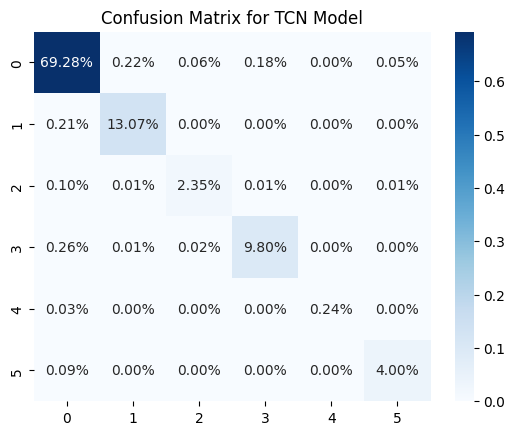

In [ ]:
import seaborn as sns
labels = ['0', '1', '2', '3', '4', '5']
conf_matrix = confusion_matrix(np.argmax(raw_results['true'], axis=-1), np.argmax(raw_results['pred'], axis=-1))
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot = True, fmt = '.2%', cmap = 'Blues', xticklabels = labels, yticklabels = labels).set(title = 'Confusion Matrix for TCN Model')

In [ ]:
## saving the model
model.save_weights('/content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/Training/Weights')

In [ ]:
## Only run if want to load the model weights
model = create_model(
    num_classes = 6,
    train_data_shape = X_train.shape,
    dropout_rate = 0.2,
    nb_filters = 64,
    nb_stacks = 1,
    kernel_size = 3,
    dilation_count = 4,
    padding_mode = 'same',
)

batch_size = 32

model.load_weights('/content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/Training/Weights')

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 25, 100)]         0         
                                                                 
 tcn_7 (TCN)                 (None, 25, 64)            112192    
                                                                 
 time_distributed_7 (TimeDi  (None, 25, 6)             390       
 stributed)                                                      
                                                                 
Total params: 112582 (439.77 KB)
Trainable params: 112582 (439.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 6. Subject-based Model

While K-fold generally is a great and widely used evaluation method, we can see that our dataset consists of data taken by subjects. This means that we have to take into account the behavior of each individuals, which might result in a more unique data from each subject.

Our another approach to the evaluation method is the subject-based evaluation. Suppose there are 10 subjects in our dataset, we will create a loop of 10 where in each iteration a model will be trained using the data from 9 subjects, while the remaining 1 will be used as the test data. This process is done 10 times, resulting 10 different models. This way, our model will be able to generate labels from unseen data, especially for new subjects (test takers).

### Building our TCN Model

We have also seen that based on our previous experiments, the XGBClassifier could not keep up with the TCN's performance. To minimize the training session, we will straight up only use TCN for this evaluation method.

The code below will be mostly the same as before. So repeated codes will have no explanations.

#### 1. Concatenating All Dataset into a Single Numpy Array

In [ ]:
x = []
y = []
y_onehot = []
label_full = pd.DataFrame(columns = ['label'])
label_shape = []
counter = 0

## Looping only through the dataset folders
for directory_path in glob.glob('/content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/*')[0:10]:
    counter = counter + 1
    folderName = directory_path.split('\\')[-1]
    print("Working with file in Folder: " + folderName)
    x.append([])
    y.append([])

    for csv_path in glob.glob(os.path.join(directory_path, "*preprocessed2.csv")):
      df = pd.read_csv(csv_path, index_col = 0)
      df_length = len(df)
      label_shape.append(df_length)
      label_full = pd.concat([label_full, df[['label']]])

      df_label = df['label']
      df = df.drop(columns = ['label'])

      x[-1].append(np.hstack([np.reshape(np.array(df[col]), (-1, 1)) for col in df.columns]))
      assert x[-1][-1].dtype == np.float64
      y[-1].append(df_label.astype('int64'))

label_binarizer = LabelBinarizer()
label_ohe = label_binarizer.fit_transform(label_full['label'].astype('int64'))

start = 0
y_onehot = []
for i in label_shape:
    end = i
    y_onehot.append([])
    y_onehot[-1].append(label_ohe[start:(start + end)])
    start = i

Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject1
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject2
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject3
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject4
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject5
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject6
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject7
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject8
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (Sm

In [ ]:
## Saving the augmented data into HDF5 file
path_h5 = '/content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject_all_preprocessed.h5'
pickle.dump({'data_X': x, 'data_Y': y, 'data_Y_one_hot': y_onehot},
                        open(path_h5, 'wb'))

#### 2. Extracting Temporal Features

In [ ]:
## Load the saved concatenated HDF5 file
path_h5 = '/content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject_all_preprocessed.h5'
loaded_data = pickle.load(open(path_h5, 'rb'))
data_X, data_Y, data_Y_one_hot = loaded_data['data_X'], loaded_data['data_Y'], loaded_data['data_Y_one_hot']

The functions below will generate temporal windows across the dataset with fixed size.

In [ ]:
def zip_equal(*args):
    fallback = object()
    for combination in itertools.zip_longest(*args, fillvalue = fallback):
        yield combination

def extract_windows(x, y, window_length, padding_features, downsample):
    res_x = []
    res_y = []

    for x_item, y_item in zip_equal(x, y):
        padding_size_x = padding_features
        padding_size_y = 0

        padded_x = np.pad(x_item, ((padding_size_x, padding_size_x), (0, 0)), 'reflect')
        padded_y = np.pad(y_item, ((padding_size_y, padding_size_y), (0, 0)), 'constant')

        window_length_x = window_length + 2 * padding_features
        res_x += [padded_x[i:i + window_length_x, :] for i in range(0, padded_x.shape[0] - window_length_x + 1, downsample)]
        res_y += [padded_y[i:i + window_length, :] for i in range(0, padded_y.shape[0] - window_length + 1, downsample)]

    return res_x, res_y

Extracting temporal features from dataset

In [ ]:
window_size = 50
overlap = 40
downsample = window_size - overlap
padding_features = 0

windows_x = []
windows_y = []

for subset_index in range(len(data_X)):
    x, y, = extract_windows(
        data_X[subset_index],
        data_Y_one_hot[subset_index],
        window_length = window_size,
        downsample = downsample,
        padding_features = padding_features
    )
    windows_x.append(np.array(x))
    windows_y.append(np.array(y))

#### 3. Modelling

In constrast to our previous approach, here we dont need to do train & test split on our data.

Defining both the metric functions and model creation

In [ ]:
def f1_score_function(y_true, y_pred):
    num_classes = y_pred.shape[-1]
    f1_scores = []
    for class_i in range(num_classes):
        pred_labels = K.argmax(y_pred, axis=-1)
        tp = K.sum(K.cast(y_true[:, :, class_i], 'float64') * K.cast(K.equal(pred_labels, class_i), 'float64'))
        all_p_detections = K.sum(K.cast(K.equal(pred_labels, class_i), 'float64'))
        all_p_true = K.sum(y_true[:, :, class_i])

        precision = tp / (all_p_detections + K.epsilon())
        recall = tp / (tf.cast(all_p_true, tf.float64) + K.epsilon())
        f_score = 2 * precision * recall / (precision + recall + K.epsilon())

        f1_scores.append(f_score)

    overall_f1_score = K.mean(K.stack(f1_scores), axis=0)
    return overall_f1_score

In [ ]:
def create_model(num_classes, train_data_shape, dropout_rate, nb_filters, nb_stacks, kernel_size, dilation_count, padding_mode):

    in_model = Input(batch_shape = (None, train_data_shape[1], train_data_shape[2]))

    model = TCN(return_sequences = True,
                dropout_rate = dropout_rate,
                nb_filters = nb_filters,
                nb_stacks = nb_stacks,
                kernel_size = kernel_size,
                dilations = [2**i for i in range(dilation_count)],
                padding = padding_mode,
                activation = 'relu',
                kernel_initializer = 'random_uniform',
                use_batch_norm = False
                )(in_model)

    out_model = TimeDistributed(Dense(num_classes, activation = 'softmax'))(model)

    model = Model(in_model, out_model)
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy',
                        metrics = ['accuracy', f1_score_function])
    model.summary()

    return model

Instead of defining a function to evaluate the model using the KCV method, we will define a new function to evaluate the model performance with subject-based evaluation.

In [ ]:
def evaluate_test_subjectbased(
    model, X, y,
    correct_for_unknown_class = True,
    padding_features = 0,
    temporal_padding = False,
    split_by_items = True,
):

    res_Y = []
    res_X = []

    window_length = model.output_shape[1]
    downsample = window_length

    items_start = []
    items_end = []

    """
    The code below is generally the same as the one to generate temporal sliding windows.
    """
    for x_item, y_item in zip_equal(X, y):
        items_start.append(len(res_X))

        ## how much padding is needed additionally, for full-window size
        target_length = int(math.ceil(x_item.shape[0] / float(window_length)) * window_length)
        padding_size_x = [0, target_length - x_item.shape[0]]
        padding_size_y = [0, target_length - y_item.shape[0]] if y_item is not None else [0, 0]

        padding_size_x = [elem + padding_features for elem in padding_size_x]

        if temporal_padding:
            padding_size_x = [elem + window_length / 2 for elem in padding_size_x]
            padding_size_y = [elem + window_length / 2 for elem in padding_size_y]

        padded_x = np.pad(x_item, (padding_size_x, (0, 0)), 'reflect')  # x is padded with reflections to limit artifacts
        padded_y = np.pad(y_item, (padding_size_y, (0, 0)), 'constant')  # y is zero-padded to ignore those labels

        window_length_x = window_length + 2 * padding_features
        res_X += [padded_x[i:i + window_length_x, :] for i in
                  range(0, padded_x.shape[0] - window_length_x + 1, downsample)]

        res_Y += [padded_y[i:i + window_length, :] for i in
                  range(0, padded_y.shape[0] - window_length + 1, downsample)]

        items_end.append(len(res_X))

    res_X = np.array(res_X)
    res_Y = np.array(res_Y)

    batch_size = 128
    original_len = res_X.shape[0]
    target_len = int(np.ceil(float(original_len) / batch_size)) * batch_size
    res_X = np.pad(res_X,
                   pad_width=((0, target_len - res_X.shape[0]), (0, 0), (0, 0)),
                   mode='constant')

    """
    The windows are generated, we can feed them into the trained model.
    """
    res_proba = model.predict(res_X, batch_size=batch_size)[:original_len]

    results = {}

    res = np.argmax(res_proba, axis=-1)
    raw_results = {'true': res_Y, 'pred': res_proba}

    ## Getting both the accuracy and F1 Score
    results['accuracy'] = (np.mean(res == np.argmax(res_Y, axis=-1)))

    results['f1_score'] = float(str(f1_score_function(res_Y, res_proba).numpy()))

    if split_by_items:
        split_res_true = [] if res_Y is not None else None
        split_res_pred = []
        for individual_start, individual_end in zip_equal(items_start, items_end):
            if res_Y is not None:
                split_res_true.append(raw_results['true'][individual_start:individual_end])
            split_res_pred.append(raw_results['pred'][individual_start:individual_end])
        raw_results = {'true': split_res_true, 'pred': split_res_pred}

    return raw_results, results

In [ ]:
## Generate file names for looping purposes
subject_names = []
counter = 0
## Please change the path inside the glob since the slicing process is done manually (to get the subject names)
for directory_path in glob.glob('/content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/*')[0:10]:
    counter = counter + 1
    folderName = directory_path.split('\\')[-1]
    subject_name = folderName[77:]
    print("Working with file in Folder: " + folderName)
    subject_names.append(subject_name)

Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject1
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject2
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject3
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject4
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject5
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject6
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject7
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/subject8
Working with file in Folder: /content/drive/MyDrive/Notebook Projects/2024 - (Sm

The code below will run a loop of 10 (total subjects)

Training model, excluding: subject1
Total amount of windows:  4646
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 50, 100)]         0         
                                                                 
 tcn_8 (TCN)                 (None, 50, 64)            112192    
                                                                 
 time_distributed_8 (TimeDi  (None, 50, 6)             390       
 stributed)                                                      
                                                                 
Total params: 112582 (439.77 KB)
Trainable params: 112582 (439.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
131/131 [==============================] - 6s 13ms/step - loss: 0.8720 - accuracy: 0.7228 - f1_score_function: 0.1787 - val_loss: 1.2090 - 

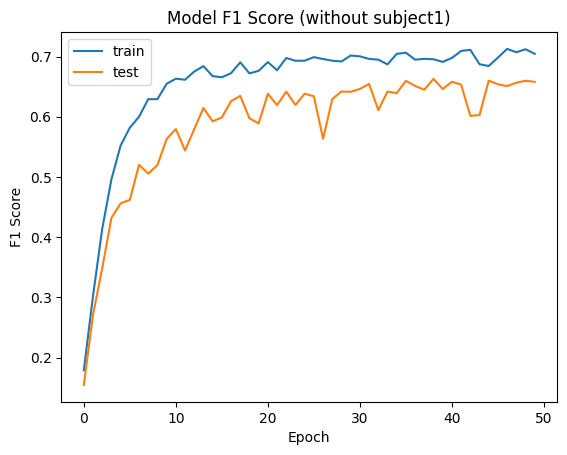

1/1 [==============================] - 1s 508ms/step
Evaluation report (no subject1):
{'accuracy': 0.5685057471264368, 'f1_score': 0.1656251728233656}
Training model, excluding: subject2
Total amount of windows:  4598
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 50, 100)]         0         
                                                                 
 tcn_9 (TCN)                 (None, 50, 64)            112192    
                                                                 
 time_distributed_9 (TimeDi  (None, 50, 6)             390       
 stributed)                                                      
                                                                 
Total params: 112582 (439.77 KB)
Trainable params: 112582 (439.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

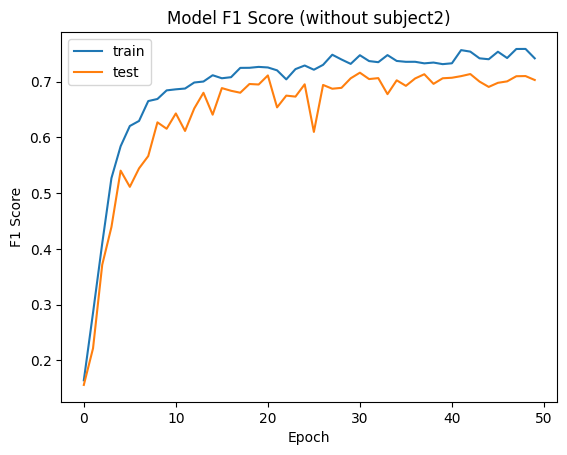

1/1 [==============================] - 0s 233ms/step
Evaluation report (no subject2):
{'accuracy': 0.5791752577319588, 'f1_score': 0.22156603381430864}
Training model, excluding: subject3
Total amount of windows:  4618
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 50, 100)]         0         
                                                                 
 tcn_10 (TCN)                (None, 50, 64)            112192    
                                                                 
 time_distributed_10 (TimeD  (None, 50, 6)             390       
 istributed)                                                     
                                                                 
Total params: 112582 (439.77 KB)
Trainable params: 112582 (439.77 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________________________________

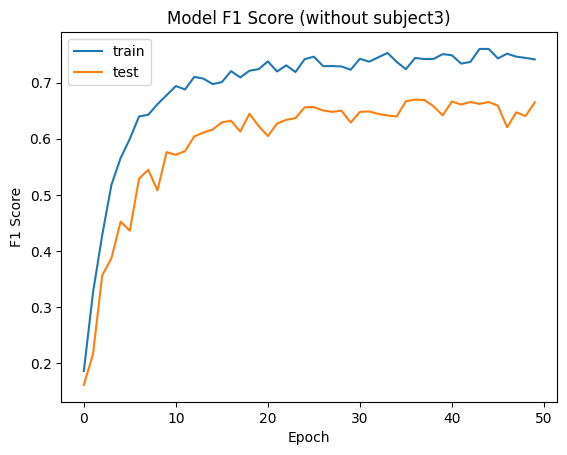

1/1 [==============================] - 0s 231ms/step
Evaluation report (no subject3):
{'accuracy': 0.6060215053763441, 'f1_score': 0.16305350169297889}
Training model, excluding: subject4
Total amount of windows:  4639
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 50, 100)]         0         
                                                                 
 tcn_11 (TCN)                (None, 50, 64)            112192    
                                                                 
 time_distributed_11 (TimeD  (None, 50, 6)             390       
 istributed)                                                     
                                                                 
Total params: 112582 (439.77 KB)
Trainable params: 112582 (439.77 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________________________________

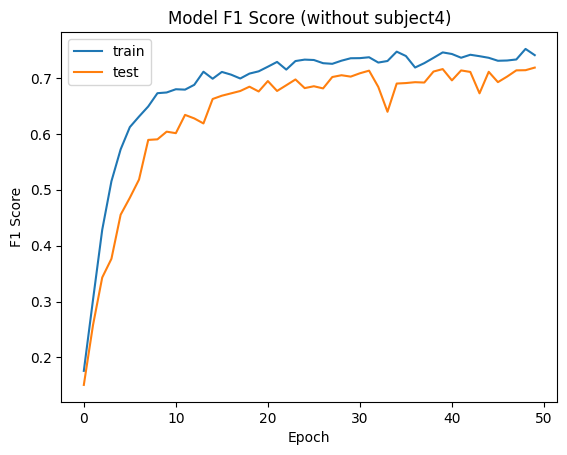

1/1 [==============================] - 0s 234ms/step
Evaluation report (no subject4):
{'accuracy': 0.5931818181818181, 'f1_score': 0.18104175983278892}
Training model, excluding: subject5
Total amount of windows:  4650
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 50, 100)]         0         
                                                                 
 tcn_12 (TCN)                (None, 50, 64)            112192    
                                                                 
 time_distributed_12 (TimeD  (None, 50, 6)             390       
 istributed)                                                     
                                                                 
Total params: 112582 (439.77 KB)
Trainable params: 112582 (439.77 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________________________________

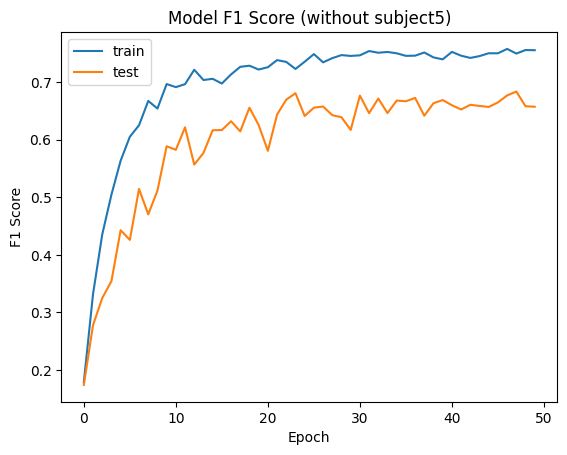

1/1 [==============================] - 1s 860ms/step
Evaluation report (no subject5):
{'accuracy': 0.5655813953488372, 'f1_score': 0.1390650263779809}
Training model, excluding: subject6
Total amount of windows:  4529
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 50, 100)]         0         
                                                                 
 tcn_13 (TCN)                (None, 50, 64)            112192    
                                                                 
 time_distributed_13 (TimeD  (None, 50, 6)             390       
 istributed)                                                     
                                                                 
Total params: 112582 (439.77 KB)
Trainable params: 112582 (439.77 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________

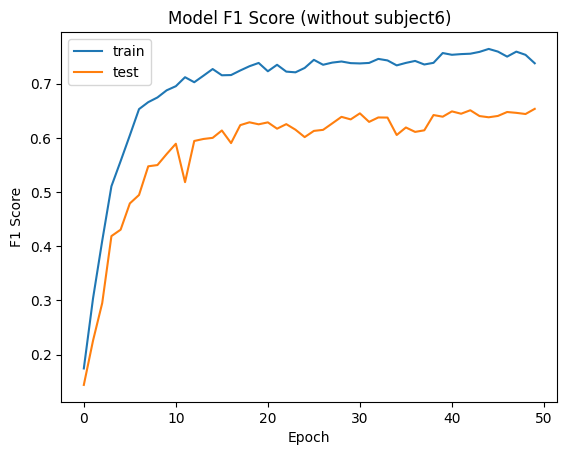

1/1 [==============================] - 0s 246ms/step
Evaluation report (no subject6):
{'accuracy': 0.5738181818181818, 'f1_score': 0.1475034865456004}
Training model, excluding: subject7
Total amount of windows:  4607
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 50, 100)]         0         
                                                                 
 tcn_14 (TCN)                (None, 50, 64)            112192    
                                                                 
 time_distributed_14 (TimeD  (None, 50, 6)             390       
 istributed)                                                     
                                                                 
Total params: 112582 (439.77 KB)
Trainable params: 112582 (439.77 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________

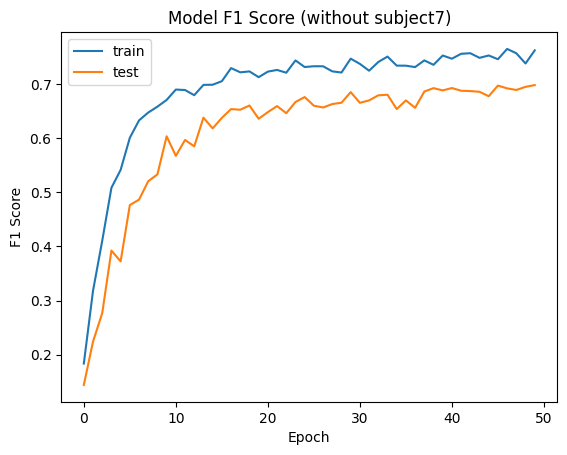

1/1 [==============================] - 0s 236ms/step
Evaluation report (no subject7):
{'accuracy': 0.6528421052631579, 'f1_score': 0.15674755745980581}
Training model, excluding: subject8
Total amount of windows:  4521
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 50, 100)]         0         
                                                                 
 tcn_15 (TCN)                (None, 50, 64)            112192    
                                                                 
 time_distributed_15 (TimeD  (None, 50, 6)             390       
 istributed)                                                     
                                                                 
Total params: 112582 (439.77 KB)
Trainable params: 112582 (439.77 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________________________________

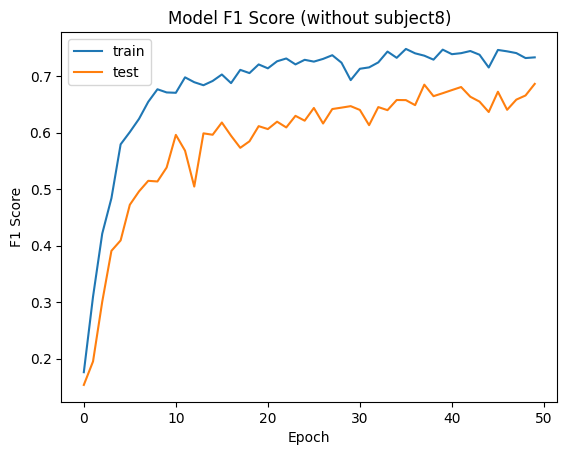

1/1 [==============================] - 0s 240ms/step
Evaluation report (no subject8):
{'accuracy': 0.5796428571428571, 'f1_score': 0.14963032002564178}
Training model, excluding: subject9
Total amount of windows:  4548
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 50, 100)]         0         
                                                                 
 tcn_16 (TCN)                (None, 50, 64)            112192    
                                                                 
 time_distributed_16 (TimeD  (None, 50, 6)             390       
 istributed)                                                     
                                                                 
Total params: 112582 (439.77 KB)
Trainable params: 112582 (439.77 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________________________________

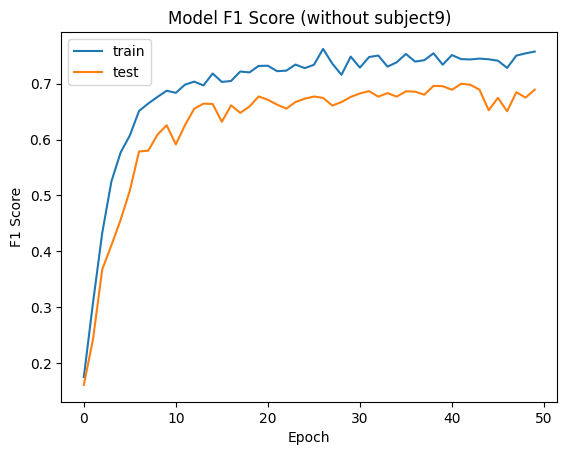

1/1 [==============================] - 0s 231ms/step
Evaluation report (no subject9):
{'accuracy': 0.6267289719626168, 'f1_score': 0.1657499533781638}
Training model, excluding: subject10
Total amount of windows:  4310
Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 50, 100)]         0         
                                                                 
 tcn_17 (TCN)                (None, 50, 64)            112192    
                                                                 
 time_distributed_17 (TimeD  (None, 50, 6)             390       
 istributed)                                                     
                                                                 
Total params: 112582 (439.77 KB)
Trainable params: 112582 (439.77 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________________________________

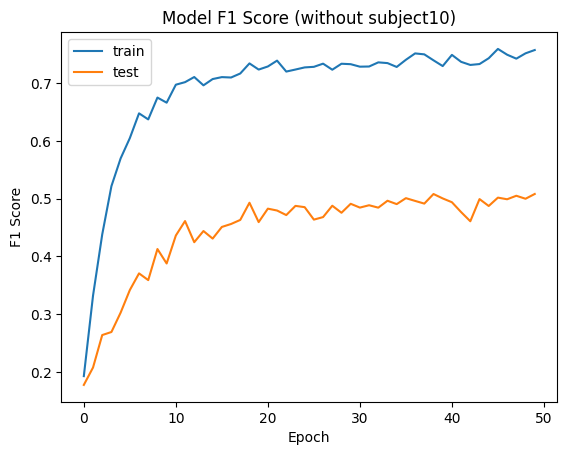

2/2 [==============================] - 0s 5ms/step
Evaluation report (no subject10):
{'accuracy': 0.5928571428571429, 'f1_score': 0.14355051104408584}


In [ ]:
## Loop for all the subjects in the dataset
for i, subject_name in enumerate(subject_names):
    print("Training model, excluding: " + subject_name)
    r = np.random.RandomState(0)
    train_set_len = sum([len(windows_x[j]) for j in range(len(windows_x)) if j != i])
    print('Total amount of windows: ', train_set_len)

    perm = r.permutation(train_set_len)
    train_x = []
    train_y = []

    indices_range_low = 0
    for j in range(len(windows_x)):
        if j == i:
            continue
        indices_range_high = indices_range_low + len(windows_x[j])
        local_indices = perm[(perm >= indices_range_low) * (perm < indices_range_high)]
        local_indices -= indices_range_low

        train_x.append(windows_x[j][local_indices])
        train_y.append(windows_y[j][local_indices])

        indices_range_low = indices_range_high

    train_x = np.concatenate(train_x)
    train_y = np.concatenate(train_y)

    model = create_model(
        num_classes = 6,
        train_data_shape = X_train.shape,
        dropout_rate = 0.2,
        nb_filters = 64,
        nb_stacks = 1,
        kernel_size = 3,
        dilation_count = 4,
        padding_mode = 'same',
    )

    history = model.fit(
        train_x, train_y,
        epochs = 50,
        batch_size = 32,
        shuffle = True,
        validation_split = 0.1,
        verbose = 1,
        initial_epoch = 0
    )

    print('Saving model..')
    model.save('/content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/Training/Subject Based/TCN_proctoring_without_{}.h5'.format(subject_name))

    plt.plot(history.history['f1_score_function'])
    plt.plot(history.history['val_f1_score_function'])
    plt.title('Model F1 Score (without {})'.format(subject_name))
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()

    raw, preprocessed = evaluate_test_subjectbased(
        model,
        data_X[i],
        data_Y_one_hot[i],
        padding_features = padding_features,
    )

    print('Evaluation report (no {}):'.format(subject_name))
    print(preprocessed)

In [ ]:
model_test = tf.keras.models.load_model('/content/drive/MyDrive/Notebook Projects/2024 - (SmartJen) Proctoring System/Training/Subject Based/TCN_proctoring_without_subject1.h5',
                      custom_objects= {'f1_score_function': f1_score_function, 'TCN':TCN})

In [ ]:
model_test.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 50, 100)]         0         
                                                                 
 tcn_8 (TCN)                 (None, 50, 64)            112192    
                                                                 
 time_distributed_8 (TimeDi  (None, 50, 6)             390       
 stributed)                                                      
                                                                 
Total params: 112582 (439.77 KB)
Trainable params: 112582 (439.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We can see that while the training process generally went smoothly with relatively good performance, the testing process indicates a bad performance between all the subjects.

This shows that all of our models cannot generalize good enough on unseen data. This also shows why a subject-based evaluation method is important.

## 7. Conclusion

Based on the experiments done, we can conclude a few things:

1. While the raw data is in a form of a video, the preprocessing and modelling step can be done by converting it into a series of images.
2. Instead of using vanilla 2D-CNN as the classifier, we can use TCN as the classifier because of its capability to support multirow predictions while also being causal.
3. The VGG16 pre-trained model can be used as a feature extractor for our images, where the number of features can also be reduced by performing PCA.
4. The processed data can be put straight away into traditional ML models such as XGBoost, or can be further explored by extracting its temporal features to be fed into more advanced models such as TCN.
5. Subject-based evaluation shows that all of the trained models cannot generalize well enough to the unseen data. A further development is suggested to collect more data from more subjects, or expanding the image extraction frequency (from 5 FPS to its original 25 FPS).